# Response Estimation

In [9]:
# Fix RC overwriting
%config InlineBackend.rc = {}

from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from mplhep.styles import ROOT
from scipy.fft import irfft, rfft
from scipy.optimize import minimize_scalar
from texat.signal.waveforms import GET_response, gaussian

plt.style.use(ROOT)
plt.rc("figure", figsize=(10, 5), dpi=120)

data_path = Path("data")

Channels which employ the AGET shaper require deconvolution in order to recover the underlying signal. This process requires a good knowledge of the underlying response function of the system. An approximate analytical solution is given in {cite:ps}`giovinazzo_get_2016`:
:::{math}
:label: get-response

h(t) = A \cdot \exp \left(-3 \frac{t}{\tau}\right) \cdot\left(\frac{t}{\tau}\right)^{3} \cdot \sin \left(\frac{t}{\tau}\right)\,,\\
:::
for {math}`\tau=\frac{\tau_s}{\delta t}`, where {math}`\tau` is the shaping time and {math}`\delta t` the reciprocal sampling rate. The authors note, however, that it is insufficiently accurate to be used with deconvolutional methods. Whilst the electronics can be configured such that the response function can be directly measured, this would have required further access to the detector which resides at the Cyclotron Institute, Texas A&M University.{cite:ps}`giovinazzo_get_2016` Without the ability to experimentally derive a response function, an estimate was determined through two separate methods.

:::{admonition} To Do
:class: margin

Show visual example of convolution
:::

## Iterative Estimation
In order to determine a better approximation for the response function, an iterative deconvolve-fit process can be applied to a set of MicroMeGaS waveforms. These waveforms should be taken from a random spanning sample of the recorded MicroMeGaS waveforms (see {numref}`mm-random-sample`). 

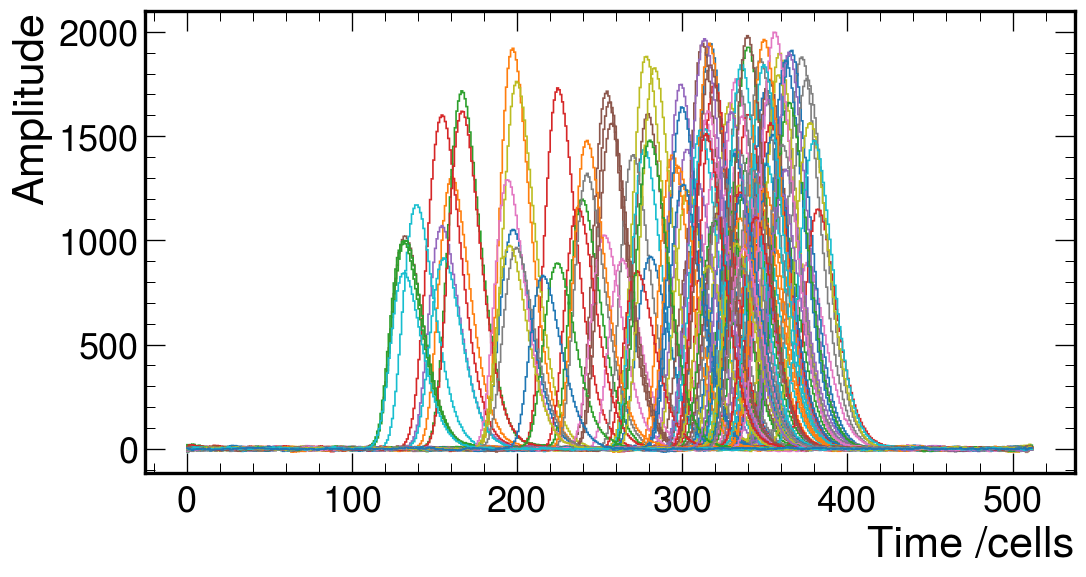

In [3]:
sample_mm = np.load(data_path / "sample-mm.npy")

plt.figure()
for s in sample_mm:
    plt.stairs(s)
plt.xlabel("Time /cells")
plt.ylabel("Amplitude");

Given such a sample, an initial estimate of the response function $F^{(1)}$ can be used to fit each waveform with the convolution of a Gaussian function:

:::{math}
:label: iterative-estimate

Y^{(1)} = F^{(1)} * \mathcal{N}^{(1)}\,,
:::

where the initial function {math}`F^{(1)}` can be determined from {eq}`get-response` with {math}`\tau = 502\,\text{ns}` (see {numref}`mm-response-shaping`).{cite:ps}`giovinazzo_get_2016`

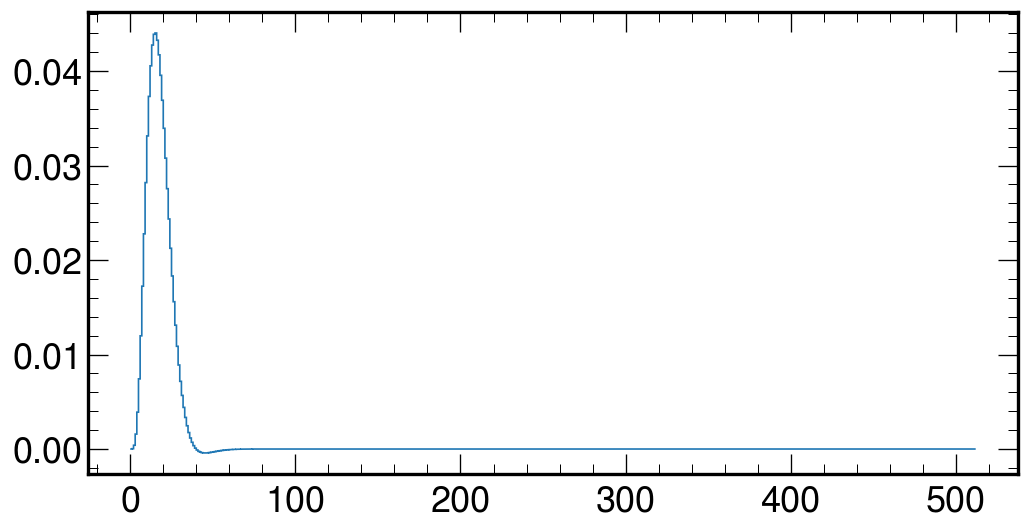

In [18]:
t = np.arange(512)

plt.xlabel("Time /cells")
plt.ylabel("Amplitude")
plt.stairs(GET_response(t, 1.0, 502 / 40));

The resulting fit $\mathcal{N}^{(1)}$ can then be _deconvolved_ from the original sample $Y$ to yield $F^{(2)}$. This process can be repeated until the solution becomes stable, and the solutions for a set of random waveforms may be averaged to produce a singular response function $F$ (see {numref}`mm-response-evolution`).


:::{math}
:label: iterative-estimate-steps

Y^{(1)} &= F^{(1)} * \mathcal{N}^{(1)}\,,

F^{(2)} &= \operatorname{Deconv}(Y^{(1)}, \mathcal{N}^{(1)})\,,

&\,\,\, \vdots

Y^{(n-1)} &= F^{(n-1)} * \mathcal{N}^{(n-1)}\,,

F^{(n)} &= \operatorname{Deconv}(Y^{(n-1)}, \mathcal{N}^{(n-1)})\,,
:::


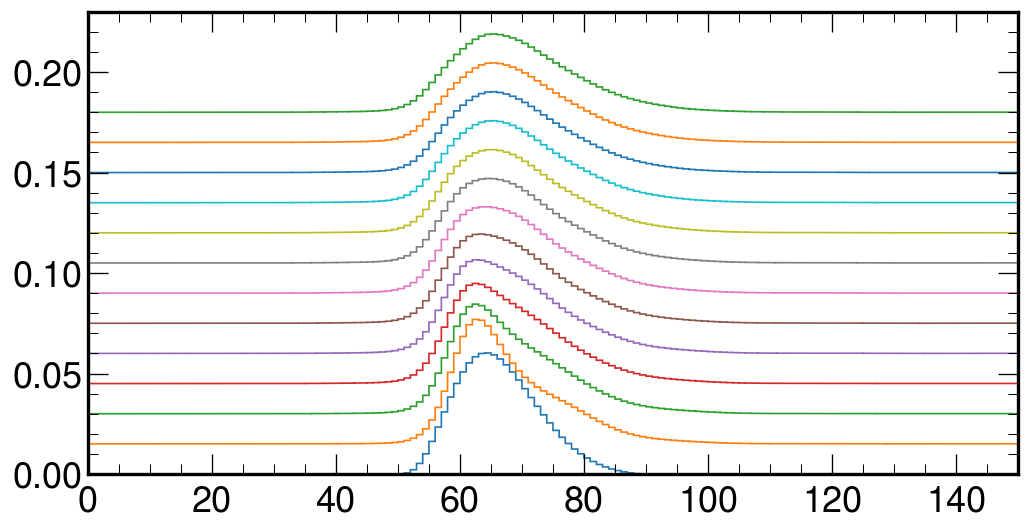

In [53]:
response = np.load(data_path / "response-evolution.npy")

for j, r_j in enumerate(response):
    if j % 5:
        continue
    plt.stairs(np.roll(r_j, 64) + j * 0.003)

plt.xlabel("Time /cells")
plt.ylabel("Amplitude")
plt.xlim(0, 1_50);

The initial trial function shown in {numref}`mm-response-evolution` is a poor fit with respect to the final response function. The convergence of the fit can be improved by first optimising the parameter $\tau$ using a convolution fit (see {numref}`cost-tau`).

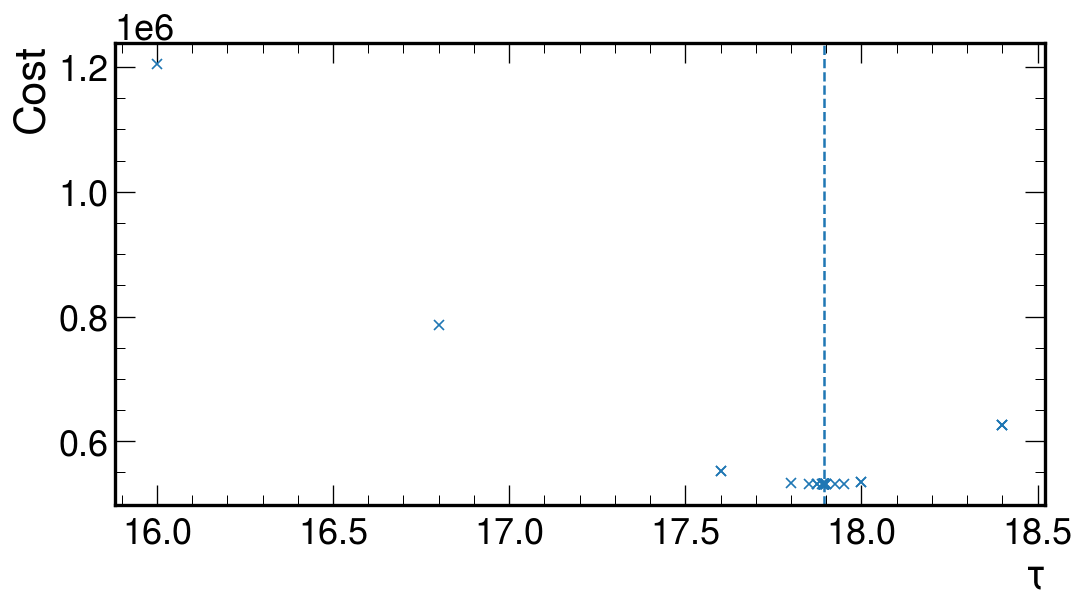

In [22]:
fit_cost = np.load(data_path / "fit-cost.npy")
tau_min = fit_cost[np.argmin(fit_cost[:, 1]), 0]

plt.axvline(tau_min, linestyle="--")
plt.plot(fit_cost[:, 0], fit_cost[:, 1], "x")
plt.xlabel("$\\tau$")
plt.ylabel("Cost");

It can be seen that the fit value of {math}`\tau` is larger than the {math}`\tau=502\,\text{ns}` that was taken from the literature (see {numref}`mm-response-initial-tau`).

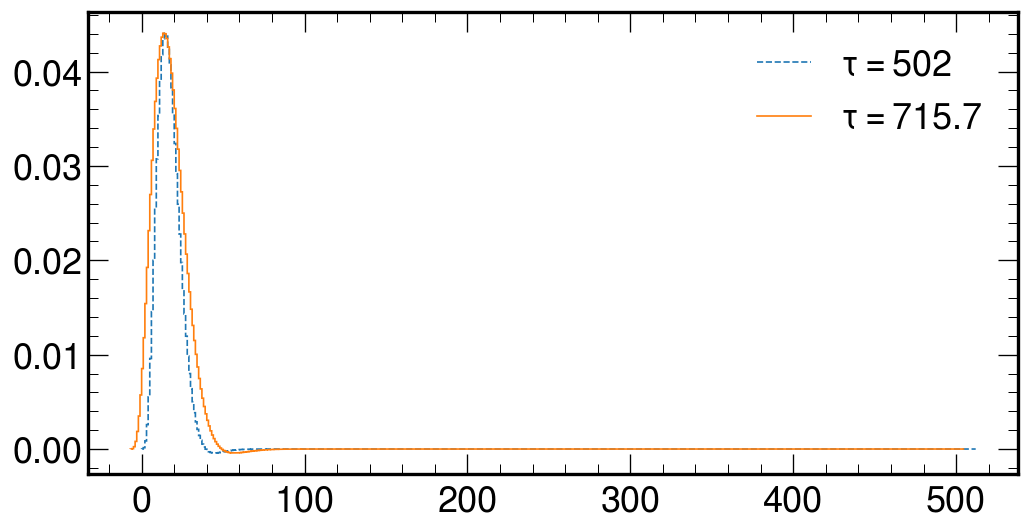

In [42]:
t_edge = np.arange(513)
t = (t_edge[1:] + t_edge[:-1]) / 2
plt.stairs(
    GET_response(t, 1.0, 502 / 40), t_edge, linestyle="--", label="$\\tau = 502$"
)
plt.stairs(GET_response(t, 1.0, tau_min), t_edge - 7, label="$\\tau = 715.7$")
plt.xlabel("Time /cells")
plt.ylabel("Amplitude")
plt.legend();

Performing another estimate of $F$ using {eq}`iterative-estimate-steps` converges to a solution much more quickly (see {numref}`mm-response-evolution-tau`), with little change in macroscopic shape.

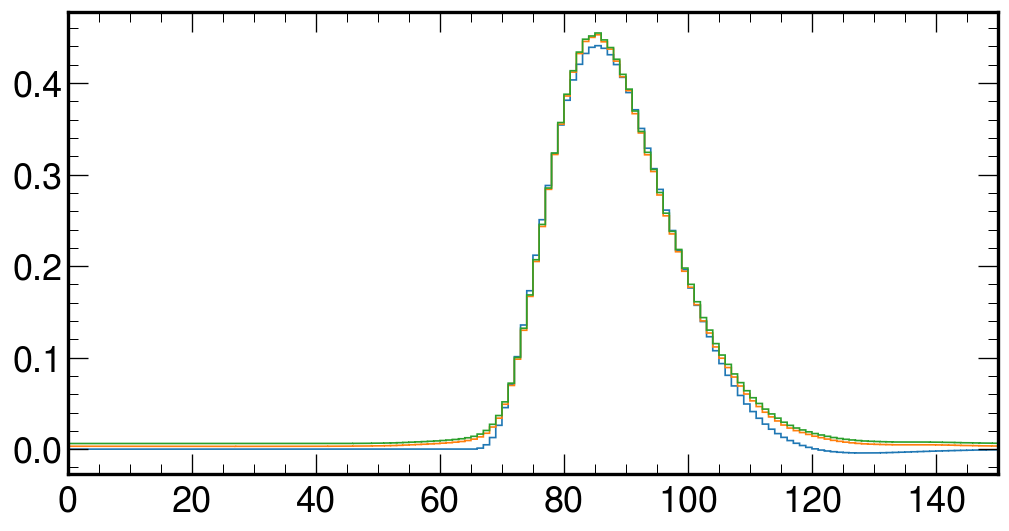

In [54]:
response_fit = np.load(data_path / "response-evolution-initial-fit.npy")

for j, r_j in enumerate(response_fit):
    plt.stairs(np.roll(r_j, 64) + j * 0.003)

plt.xlabel("Time /cells")
plt.ylabel("Amplitude")
plt.xlim(0, 1_50);

The final response function estimate also agrees with that computed from the published {math}`\tau`. A comparison of the two solutions is shown in {numref}`mm-response-final-comparison`.

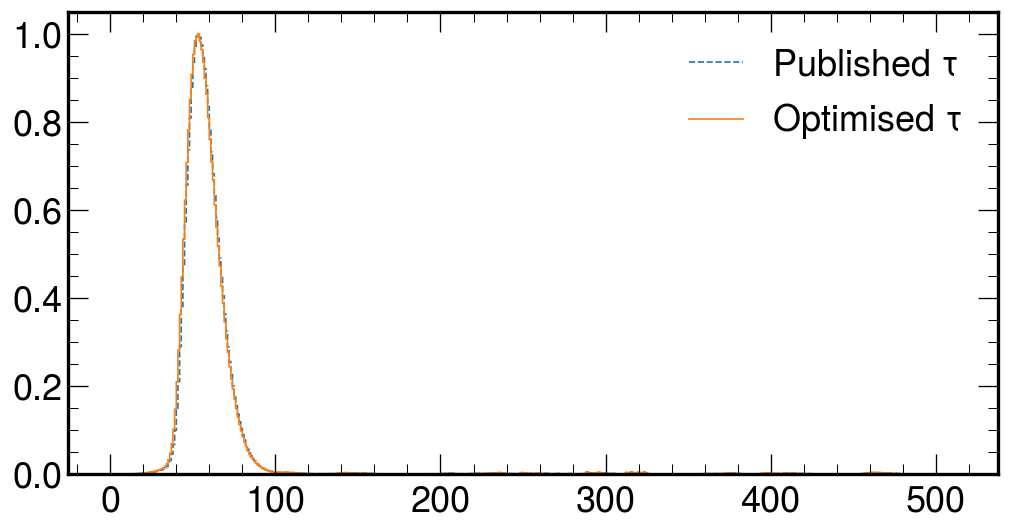

In [64]:
plt.stairs(
    np.roll(response[-1], 32 + 20) / np.max(response[-1]),
    t_edge,
    linestyle="--",
    label="Published $\\tau$",
)
plt.stairs(
    np.roll(response_fit[-1], 32) / np.max(response_fit[-1]),
    t_edge,
    label="Optimised $\\tau$",
)
plt.xlabel("Time /cells")
plt.ylabel("Amplitude")
plt.legend();

That the published value of {math}`\tau` does not agree with the value determined in {numref}`cost-tau` is not necessarily surprising. Given that the convolution of any two Gaussians is also Gaussian, the solution from {eq}`iterative-estimate` is not guaranteed to be unique, i.e. the resulting response function may include some Gaussian component common to the sampled waveforms. 

## Sample Averaging

As discussed in <TODO>, the width of the deconvolved GET waveforms in the MicroMeGaS is partially determined by the shape of the charge clusters formed in the detector, i.e. the elevation of the path travelled by ionising radiation. This additional degree of freedom is accounted for above through the Gaussian convolution fit. It follows that the silicon waveforms may provide a more robust estimate of the GET response function, as the shape of the current signal produced by interactions with the silicon detector is predominantly determined by the shaper. 
    
To first approximation, the measured signal can be assumed to be the convolution of the delta function at some time $t$ and the intrinsic response function.
To build a response function estimate, a random sample of silicon waveforms spanning a range of amplitudes is taken. The bin-wise mean of this set of waveforms is taken to produce an average waveform (see {numref}`si-response-average`). This waveform is an approximate response function, which can then be time-shifted such that the peak coincides with {math}`t=0`.

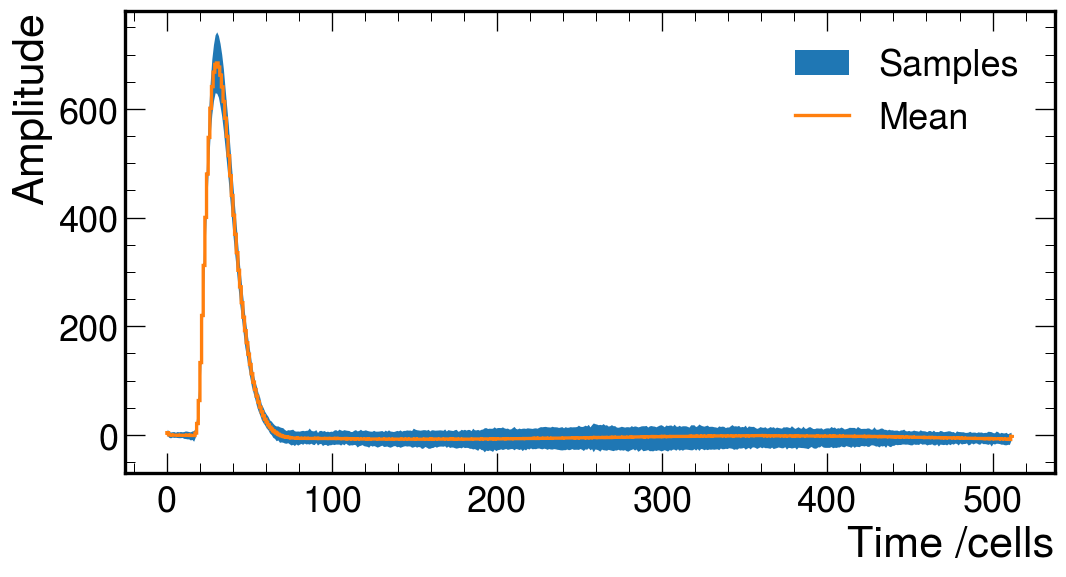

In [85]:
sample = np.load(data_path / "sample-si.npy")

y_upper = np.max(sample, axis=-2)
y_lower = np.min(sample, axis=-2)

fig, ax = plt.subplots()
ax.fill_between(t, y_upper, y_lower, label="Samples")
ax.set_xlabel("Time /cells")
ax.set_ylabel("Amplitude")
ax.stairs(sample.mean(axis=0), color="C1", linewidth=2, label="Mean")
ax.legend();

These two methods of estimating the response function of the GET electronics can be compared. In {numref}`mm-si-response-comparison` the two response function estimates are visually compared. It can be seen that the MicroMeGaS iterative-estimate response function closely resembles the silicon average response function after Gaussian broadening. As the silicon average response function is computed directly, and is narrower than that of the MicroMeGaS response, it is better suited as the response function of choice.

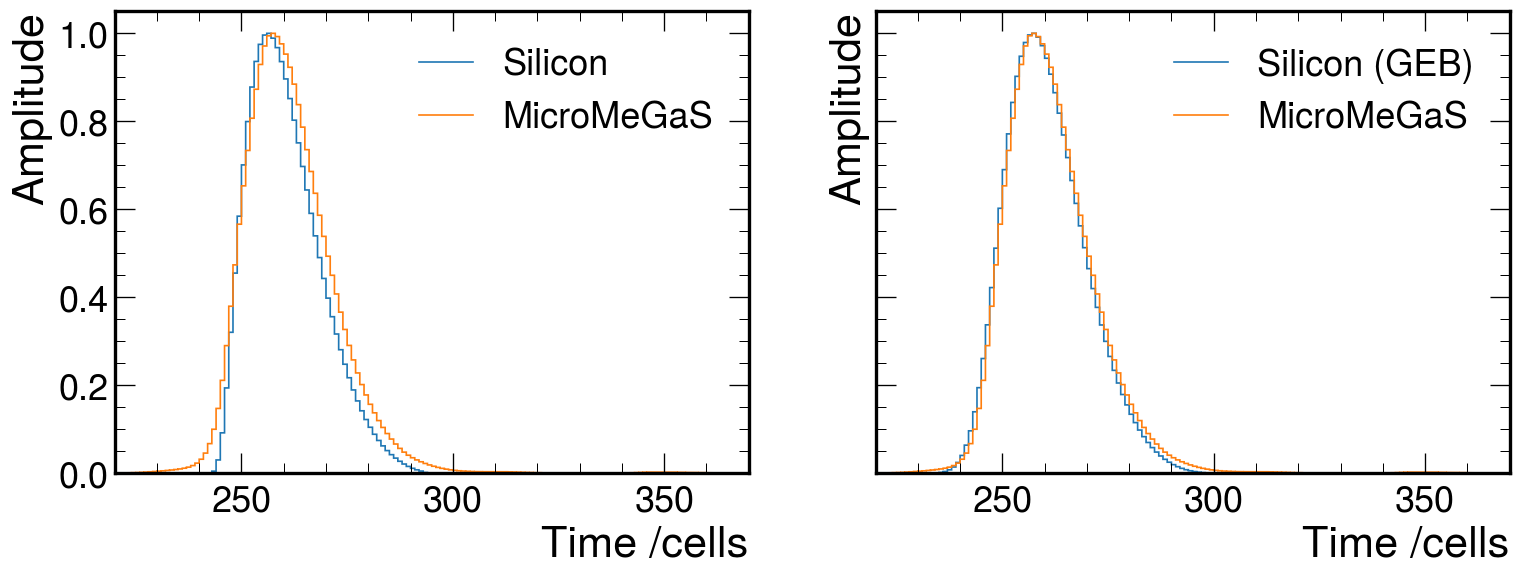

In [91]:
response_si = (response_si := np.load(data_path / "response-si.npy")) / np.max(
    response_si
)
response_mm = (response_mm := np.load(data_path / "response-mm.npy")) / np.max(
    response_mm
)


def kernel(n, sigma):
    t = np.arange(n)
    g = np.roll(gaussian(t, 1, n // 2, sigma), -n // 2)
    return g / np.sum(g)


def broaden(r, sigma):
    y = kernel(r.size, sigma)
    u = irfft(rfft(r) * rfft(y))
    return u * np.max(r) / np.max(u)


def cost(sigma):
    return np.sum((broaden(response_si, sigma) - response_mm) ** 2)


fit = minimize_scalar(cost)

response_si_broad = broaden(response_si, fit.x)
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax[0].stairs(np.roll(response_si, 256), label="Silicon")
ax[0].stairs(np.roll(response_mm, 256), label="MicroMeGaS")
ax[0].set_xlabel("Time /cells")
ax[0].set_xlim(220, 370)
ax[0].set_ylabel("Amplitude")
ax[0].legend(loc="upper right")
ax[1].stairs(np.roll(response_si_broad, 256), label="Silicon (G.B.)")
ax[1].stairs(np.roll(response_mm, 256), label="MicroMeGaS")
ax[1].set_xlabel("Time /cells")
ax[1].set_xlim(220, 370)
ax[1].set_ylabel("Amplitude")
ax[1].legend(loc="upper right");